# Italian error collection pipeline

 1. Filter the dataset words by non identified words
 2. Export erros to correction sheet
 3. Read the corrections sheet
 4. Combine all corrections
 5. Mark the dataset with the corrections
 6. Count the frequency of errors
 7. Export sheet to validation
 8. Classify the errors

In [4]:
import json
import numpy as np
import pandas as pd
import itertools
from matplotlib import pyplot as plt
import re
import string
import hunspell

In [5]:
it_spellchecker = hunspell.HunSpell('/home/rgomes/dictionaries/dictionaries/it/index.dic', '/home/rgomes/dictionaries/dictionaries/it/index.aff')

# Analyze the starting dataset
Initial analisis to identify the behavior of the dataset and words distribuition

In [6]:
def histogram(list):
    d={}
    for i in list:
        if i in d:
            d[i] += 1
        else:
            d[i] = 1
    return d

In [7]:
def histogramSorted(wordslist):
    h = histogram(wordslist)
    h = sorted(h.items(), key=lambda x: x[1], reverse=True)
    # remove the words that appears only once
    #h = filter(lambda x: x[1] > 1, h)
    return h

def plotHistogram(data):
    h = histogramSorted(data)
    h = map(lambda x: x[1], h)
    plt.plot(list(h))
    plt.show()

Total words from dataset: 1900669


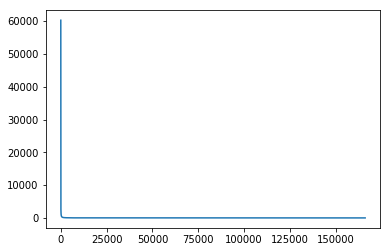

In [8]:
all_words = []
with open('../italian_words_all.txt', encoding='utf-8') as data_file_all:
    lines = data_file_all.readlines()
    all_words = list(map(lambda x: x.rstrip('\n').lower(), lines))
    all_words = list(map(lambda x: x.replace('!#$%&()*+,./:;<=>?@[\\]_{|}', ''), all_words))

print('Total words from dataset:', len(all_words))

plotHistogram(all_words)

# Working with the automatic suggestions list

In [9]:
def filterNonRecognizedWords(wordslist):
    a = map(lambda x: (x['word'], it_spellchecker.spell(x['word'])), wordslist)
    b = filter(lambda x: not x[1], a)
    return b

In [10]:
def filterRecognizedWords(wordslist):
    a = map(lambda x: (x['word'], it_spellchecker.spell(x['word'])), wordslist)
    b = filter(lambda x: x[1], a)
    return b

In [11]:
auto_spellchecker_data = []
with open('../auto.spellchecker.results.filtered.json', encoding='utf-8') as data_file_1:
    data = json.loads(data_file_1.read())
    auto_spellchecker_data = list(filter(lambda x: x,data))

# Filter the Hunspell non recognized words
auto_spellchecker_non_recognized = list(filterNonRecognizedWords(auto_spellchecker_data))

In [12]:
auto_spellchecker_non_recognized_accented = filter(lambda x: re.search(r'[√Ä-≈æ\'\`]', x[0]),
                                                   auto_spellchecker_non_recognized)
# save on a file
# and the correct the words

In [13]:
corrected_ac_errors = []
with open('../italian_accented_erros.txt', encoding='utf-8') as data_file2:
    lines = data_file2.readlines()
    corrected_ac_errors = list(filter(lambda y: y != '',map(lambda x: x.rstrip('\n'), lines)))

In [14]:
corrected_words = []
for index,x in enumerate(auto_spellchecker_non_recognized_accented):
    if x[0] != corrected_ac_errors[index]:
        corrected_words.append((x[0], corrected_ac_errors[index]))
        
len(corrected_words)

114

## Read the csv with suggestions after correction

In [15]:
suggestions_csv = pd.read_csv('/home/rgomes/Downloads/suggestions filtered - suggestions.auto.csv')

# remove empty cells
suggestions_csv = suggestions_csv.replace(np.nan, '', regex=True)

# remove unused columns
suggestions_csv.drop(['is_italian_word', 'suggestions', 'HELPFUL LINK', 'Already removed words'], axis=1)

# load the csv corrections
suggestions_corrected = []
for _, row in suggestions_csv.iterrows():
    if row['spelling_correction']:
        suggestions_corrected.append((row['word'], row['spelling_correction']))
print('Total suggestions corrected:', len(suggestions_corrected))

Total suggestions corrected: 142


## Write the most common accented words not recognized by Hunspell

In [16]:
combined_corrections_map = list(set(corrected_words + suggestions_corrected))
print('Total corrections {}'.format(len(combined_corrections_map)))
combined_words_list = list(map(lambda x : x[0].lower(), combined_corrections_map))

h_all_words = histogram(all_words)
h_all_words_sorted = sorted(h_all_words.items(), key=lambda x: x[1], reverse=True)

a_ordered = filter(lambda x: re.search(r'[√Ä-≈æ\'\`]', x[0]), h_all_words_sorted)
b_ordered = filter(lambda x: not it_spellchecker.spell(x[0]),a_ordered)
c_ordered = filter(lambda x: not(x[0] in combined_words_list),b_ordered)

accented_non_recognized = list(c_ordered)
count2 = 0
for w in accented_non_recognized:
    count2 = count2 + w[1]
print('Total accented words non recognized',count2)

# save to be corrected
with open('../ordered_last_errors.txt', 'w') as ordered_last_errors:
    for item in accented_non_recognized:
        print(item[0])
        ordered_last_errors.write(item[0] + '\n')
        
        

Total corrections 252
Total accented words non recognized 21459
e'
c‚Äô√®
√©
p√≤
piu'
citt√†,
l'
citta'
per√≤,
pi√π,
c'e'
perche'
cos√¨,
all'
gia'
l√¨,
s√¨,
dell'
c'e
puo'
n√®
'
perch√©,
(√®
cosi'
dall'italia
caff√®,
e`
pi√∫
dall'
pero'
d'
√®,
mus√©e
sara'
citta',
un'
po',
dell'isola,
citt√†!
pla√ßa
realt√†,
pi√π!
(pi√π
l√†,
li'
xch√®
th√®
sull'
libert√†,
l'auto,
f√†
citta'.
caffe'
citt√†:
anch'io,
luned√¨,
ne'
niccol√≤
s√®
curiosit√†:
gi√†,
√†
curiosit√†,
dall'italia,
d'acqua,
cio'
l'altro,
dell'hotel,
all'aperto,
l'italia
cos√¨:
vabb√®,
verit√†,
perch√®,
all'hotel,
l'audioguida
(gi√†
l'hotel,
',
tranquillit√†,
venerd√¨,
cosi`
fa'
un'ora,
met√†,
pi√π?
√®:
possibilita'
regent's
com‚Äô√®
nell'
difficolt√†,
et√†,
attivit√†,
d'europa
v√†
ges√π
(perch√©
citt√†?
dall'italia.
citt√†)
all'interno,
l'africa
'.
mezz'ora,
piu`
meta'
ahim√®,
c'
all'albergo,
king's
d'ingresso,
perche`
un'altro
per√π
√®'
all'esterno,
qualit√†,
gioved√¨,
earl's
piu',
anch'io!
corf√π
realta'
sull'isola,
all'aeroporto

seguito...l'inizio
l'ibiza
dell'adriatico)
nat√¨a.
descriver√≤:
molt√≥,
dell'aubrac
(aim√©...)
(ri-aim√©)
all'unisono...poi
(cio√®...vediamo
√®....un
pass√©?
l'avez
d√©poulp√©"
auray...vedr√≤
scendendo...l'atmosfera
l'accompagnatore)
l'accompagnatore,
all'isoladal
n'tichka
all'auto,
dell'ounila,
l'oasi,
dad√®s,
dad√®s.
un'australia
l√°,
propriet√°
approd√≥
molt√≥.
sott'olio.
dell'azienda,
salato...√®
soddisfer√†,
nazionalit√°
citt√°,
confess√≥
macquarie's
inglesi.√©
permetter√°
unicit√°
baster√°
l'echo
trasform√≥
mor√≠
mezz'oretta)
dell'australia,
dell'australia?"
l'australia"
"pola≈Çy
siƒô
rzƒôsiste,
dzieci≈Ñstwo
mojƒÖ
m≈Çodo≈õƒá
g√≥rna
durnƒÖ,
m√≥j
mƒôski,
klƒôski.
pola≈Çy
rzƒôsiste."adam
l'ulica
g≈Ç√≥wny
l'ermellino"...
un'ora.in
(l'orario
vestibolo.all'entrata
lanckoro≈Ñski.
ravensbr√ºck,
l'ermellino"
l'ammira,
l'ora.:-)dopo
d≈ºok,
d≈ºok
bronis≈Çaw
d'oro...)
agosto:e'
anticipo.l'allestimento
podg√≥rze,
bohater√≥w
dell'aquila,
d√†,
p≈Çasz√≥w,
lutto.e'
dell'arsenale,
ku≈∫nice
lass√π.

ballaro'
(dall'arabo
all'alizar.
l'alizar
l'ora"???
un'aggeggio
dall'alizar,
(l'oceano)si
speciale......l'odore
mattina,e'un
raba√ßal
'madeira'
'madeira
walks'
mountuosit√†
'palafitte'
c'eran
citt√†...se
d'amore...appena
un'idea,
l'illuminazione:
l'ora!"
normalita',
s'interrompe,
bell'aiuto,
l'agora',
cambiera'
all'orologio,
servitu'
cliche'
l'ortigia.
l'aggravante,
l'elefantino,
nell'omerta'
v√¨a
c√¨rculo
serra.tripadvisor.it/attraction_review-g-d‚Ä¶all'uscita
l'anniversario!!!!!
'sul
sicuro'.
tappe....pero'
all'altro:
ma'in,
ges√π).
di...pi√π
all'uscita;
l'etna
dell'etna.
l'etna,
dall'europa,
realta'.
negativita'
riferito,√®
all'aperto,con
curati,bamb√π
d'italia",ossia
l'orologio:
d'insieme:
po'quelli
dell'attentato:
dell'accaduto:
bell'effetto,
imerovigli.l'isola
qualita',
perissa...e'
qualita'romanticismo
la'cqua
un'atmosfera,
coppia,perch√®
l'altro,ci
perch√®,per
un'isoletta,di
d'atterraggio,senza
l'altro....ora
attrezzata,c'√®
(l'
nell'.
benvenute.quest'anno
ma,ne'
volta.l'aeropo

all''hotel
c√®spedes
l'habana
dell'habana
‚Äúdifficolt√†‚Äù
entr√®),
l√¨‚Ä¶
l'incitamento,
viaggio.l'occasione
all'australia.mi
[continuer√≤
sfott√≤
despere√®s‚Äù
l'ora!!!!!abbi
lut√®ce,
saint-germain-des-pr√©s,
all'ar√®nes
lut√®ce
saint-germain-des-pr√©s
sacr√©-coeur,
bienven√ºe.
sacr√©-coeur
d√®fense,
d√®fense.
lumenn'
‚Ä¶imageshack.us/img//pi.jpgall'aeroporto
quest'uomo,
dev'esser
mercoled'
√©lys√©es,
(men√π
dell'immacolata)
imageshack.us/photo/my-images//noiy.jpg/cos√¨
f√†!"
sull'oronte
all'arizona
dell'arizona.
dell'arizona"
l√¨????
un'altre
mondo.l'unico
dall'eroporto
dell'accoppiamento,
dell'hotel,cibo
amicizie,quest'anno
s√≤,ma
dell'airberlin,
infranser√≤
all'a
*√ß*.
et√†".
;)all'eroporto
*√ß*,
prossima.trascorrer√≤
(riuscir√≤
all'originale)puoi
dire...√®
watercolors..(.l√¨
dell'egitto
verit√†‚Äù
l√¨‚Ä¶).
et√†!!!!!!!!!!!!!
merc√®....
hoolal√†
(l'atollo
divertirvi.attivita':
libert√†!!come
(t√®)
per√≤‚Ä¶)
vedanthangal.√®
namast√®!!!!!
kenya.gioved√¨
dall'italia!
e'avventuroso
e'

## Load the most common accented words corrections

In [17]:
last_corrections = []
with open('../ordered_last_errors_corrected.txt') as ordered_last_corrections:
    lines = list(map(lambda x: x.rstrip('\n').lower(), ordered_last_corrections))
    for index, item in enumerate(accented_non_recognized):
        if item[0] != lines[index]:
            last_corrections.append((item[0],lines[index]))
print(len(last_corrections))

92


## Group all corrections realized

In [18]:
combined_corrections_map = list(set(corrected_words + suggestions_corrected + last_corrections))
print('Total corrections {}'.format(len(combined_corrections_map)))

combined_words_list = list(map(lambda x : x[0].lower(), combined_corrections_map))
mapped_combined_words = list(filter(lambda x : x[0].lower() in combined_words_list, h_all_words_sorted))

#remove rare cases and outliers
# todo: remove nonsense words verified by norton
total_words = list(filter(lambda x: x,mapped_combined_words))

count = 0
for w in total_words:
    count = count + w[1]

print('Total corrections with repetition {}'.format(count))

Total corrections 344
Total corrections with repetition 6872


## Export the corrections to verification and statistical analysis

In [19]:
all_count_dict = dict((a[0], a) for a in total_words)
all_corrections_dict = dict((a[0], a) for a in combined_corrections_map)

all_data = []
for item in all_count_dict:
    if all_corrections_dict.get(item):
        all_data.append((item, all_count_dict[item][1], all_corrections_dict[item][1]))

print(len(all_data))
df = pd.DataFrame(all_data)
df.to_csv('../final_corrections.csv')

235


In [20]:
with open('../errors_final_list.txt', 'w') as errors_list_file:
    for word in (list(df[0].values)):
        errors_list_file.write(word + '\n')

In [21]:
# make sure that all the corrections are counted, removing punctuations
print(len(set(all_words)))
# use the native python punctuation list but remove accents related like "'^`~
#print(string.punctuation)
all_words_no_punctuation = list(map(lambda x: x.rstrip('!#$%&()*+,-./:;<=>?@[\\]_{|}') ,all_words))
print(len(set(all_words_no_punctuation)))

# save to be validated and check more errors on LibreOffice
with open('../ordered_all_words_no_punctuation.txt', 'w') as file_all_1:
    for w in all_words_no_punctuation:
        file_all_1.write(w + '\n')

166011
110965


In [24]:
combined_words_list_final = list(map(lambda x : x[0].lower(), asdfgh))
mapped_combined_words_final = list(filter(lambda x : x[0].lower() in combined_words_list_final, h_all_words_sorted))

count_total = 0
for w in mapped_combined_words_final:
    count_total = count_total + w[1]

print('FINAL Total corrections with repetition {}'.format(count_total))

NameError: name 'asdfgh' is not defined

In [25]:
all_count_dict_final = dict((a[0], a) for a in mapped_combined_words_final)
all_corrections_dict_final = dict((a[0], a) for a in asdfgh)
all_data_final = []
for item in all_count_dict_final:
    if all_corrections_dict_final.get(item):
        all_data_final.append((item, all_count_dict_final[item][1], all_corrections_dict_final[item][1]))

print(len(all_data_final))
df = pd.DataFrame(all_data_final)
df.to_csv('../final_corrections2.csv')

NameError: name 'mapped_combined_words_final' is not defined

In [26]:
corrected_words + suggestions_corrected + last_corrections
last_corrections

[("e'", "\ufeffe'"),
 ('p√≤', 'po‚Äô'),
 ("piu'", 'pi√π'),
 ("citta'", 'citt√†'),
 ("c'e'", "c'√®"),
 ("perche'", 'perch√©'),
 ("gia'", 'gi√†'),
 ("c'e", "c'√®"),
 ("puo'", 'pu√≤'),
 ('pi√∫', 'pi√π'),
 ("pero'", 'per√≤'),
 ("sara'", 'sar√†'),
 ("citta',", 'citt√†,'),
 ('th√®', 't√®'),
 ("citta'.", 'citt√†.'),
 ("caffe'", 'caff√®'),
 ("ne'", 'n√©'),
 ("cio'", "ci√≤'"),
 ('perch√®,', 'perch√©,'),
 ("possibilita'", "possibilit√†'"),
 ('piu`', 'pi√π'),
 ('perche`', 'perch√©'),
 ("piu',", 'pi√π,'),
 ("realta'", 'realt√†'),
 ("giu'", 'gi√π'),
 ('caf√®,', 'caff√®,'),
 ("localita'", 'localit√†'),
 ('granch√®,', 'granch√©,'),
 ('c‚Äôe`', 'c‚Äô√®'),
 ("chissa'", 'chiss√†'),
 ("cioe'", 'cio√®'),
 ('caf√®.', 'caff√®.'),
 ("finche'", 'finch√©'),
 ('perch√®.', 'perch√©.'),
 ("difficolta'", 'difficolt√†'),
 ("disponibilita'", 'disponibilit√†'),
 ("tornero'", 'torner√≤'),
 ('affinch√®', 'affinch√©'),
 ("venerdi'", 'venerd√¨'),
 ('ahim√©', 'ahim√®'),
 ("piu'.", 'pi√π.'),
 ('(perch√®', '(perch√©'),
 ('g

In [27]:
with open('../italian_posts.txt') as italian_posts:
    it_posts = italian_posts.read()

In [28]:
len(it_posts)

12819150

In [29]:
df_corrections = pd.read_csv('/home/rgomes/Downloads/Corre√ß√µes Italiano - Corre√ß√µes.csv')
df_corrections

Palavra com erro          Corre√ß√£o  Ocorr√™ncias      Categoria de Erro 1  \
0                 e'                 √®         2201            Acento Errado   
1             perch√®            perch√©         1237            Acento Errado   
2                 p√≤               po‚Äô          568            Acento Errado   
3               piu'               pi√π          548            Acento Errado   
4             citta'             citt√†          180            Acento Errado   
5               c'e'               c'√®          145            Acento Errado   
6            perche'            perch√©          144            Acento Errado   
7               gia'               gi√†          124            Acento Errado   
8                c'e               c'√®           99            Acento Errado   
9               puo'               pu√≤           97            Acento Errado   
10              caf√®             caff√®           66          M√∫ltiplos Erros   
11               pi√∫               pi√π           60            Acento Errado   
12            poich√®            poich√©           50            Acento Errado   
13             pero'              per√≤           49            Acento Errado   
14            finch√®            finch√©           44            Acento Errado   
15             sara'              sar√†           39            Acento Errado   
16               c'√©               c'√®           34            Acento Errado   
17        aereoporto         aeroporto           32                 Inser√ß√£o   
18         dopodich√®         dopodich√©           31            Acento Errado   
19             citt√°             citt√†           28            Acento Errado   
20               th√®                t√®           27                 Inser√ß√£o   
21               qu√¨               qui           26          Falta de Acento   
22            caffe'             caff√®           26            Acento Errado   
23               ne'                n√©           25            Acento Errado   
24              cio'               ci√≤           22            Acento Errado   
25    all'aereoporto     all'aeroporto           20                 Inser√ß√£o   
26           granch√®           granch√©           20            Acento Errado   
27              caf√©             caff√®           20          M√∫ltiplos Erros   
28      possibilita'       possibilit√†           18            Acento Errado   
29            nonch√®            nonch√©           17            Acento Errado   
..               ...               ...          ...                      ...   
187      aereomobili        aeromobili            1                 Inser√ß√£o   
188       accettavan        accetavano            1                  Omiss√£o   
189            aihm√®             ahim√®            1             Transposi√ß√£o   
190         adattore        adattatore            1                  Omiss√£o   
191          fuorch√®           fuorch√©            1            Acento Errado   
192         benissmo         benissimo            1                  Omiss√£o   
193       caff√®latte       caff√® latte            1          Falta de espa√ßo   
194         mangier√≤           manger√≤            1            Acento Errado   
195          citt√†da          citt√† da            1          Falta de espa√ßo   
196           avevao           avevano            1                  Omiss√£o   
197     benearrivata      ben arrivata            1          M√∫ltiplos Erros   
198         affittao           affitto            1                 Inser√ß√£o   
199            tess√≤             tesso            1  Coloca√ß√£o Desnecess√°ria   
200  archeoculturale  archeo culturale            1          Falta de espa√ßo   
201       afffluenza         affluenza            1                 Inser√ß√£o   
202       perche'chi        perch√© chi            1          M√∫ltiplos Erros   
203          neanch√®           neanche            1  Coloca√ß√£o Desnecess√°ri

In [30]:
import shutil
shutil.copyfile('../italian_posts.txt', '../italian_posts_marked.txt')    

'../italian_posts_marked.txt'

In [31]:
for w in df_corrections["Palavra com erro"].values:
    marked_file_read = open('../italian_posts_marked.txt')
    regex = re.compile(r'\s{}\s'.format(w), re.IGNORECASE)
    print(regex)
    marked_string = re.sub(regex, " {{ # }} ".replace('#', w),marked_file_read.read())

    marked_file_write = open('../italian_posts_marked.txt', 'w')
    marked_file_write.write(marked_string)

re.compile("\\se'\\s", re.IGNORECASE)
re.compile('\\sperch√®\\s', re.IGNORECASE)
re.compile('\\sp√≤\\s', re.IGNORECASE)
re.compile("\\spiu'\\s", re.IGNORECASE)
re.compile("\\scitta'\\s", re.IGNORECASE)
re.compile("\\sc'e'\\s", re.IGNORECASE)
re.compile("\\sperche'\\s", re.IGNORECASE)
re.compile("\\sgia'\\s", re.IGNORECASE)
re.compile("\\sc'e\\s", re.IGNORECASE)
re.compile("\\spuo'\\s", re.IGNORECASE)
re.compile('\\scaf√®\\s', re.IGNORECASE)
re.compile('\\spi√∫\\s', re.IGNORECASE)
re.compile('\\spoich√®\\s', re.IGNORECASE)
re.compile("\\spero'\\s", re.IGNORECASE)
re.compile('\\sfinch√®\\s', re.IGNORECASE)
re.compile("\\ssara'\\s", re.IGNORECASE)
re.compile("\\sc'√©\\s", re.IGNORECASE)
re.compile('\\saereoporto\\s', re.IGNORECASE)
re.compile('\\sdopodich√®\\s', re.IGNORECASE)
re.compile('\\scitt√°\\s', re.IGNORECASE)
re.compile('\\sth√®\\s', re.IGNORECASE)
re.compile('\\squ√¨\\s', re.IGNORECASE)
re.compile("\\scaffe'\\s", re.IGNORECASE)
re.compile("\\sne'\\s", re.IGNORECASE)
re.compile("

re.compile('\\saereomobili\\s', re.IGNORECASE)
re.compile('\\saccettavan\\s', re.IGNORECASE)
re.compile('\\saihm√®\\s', re.IGNORECASE)
re.compile('\\sadattore\\s', re.IGNORECASE)
re.compile('\\sfuorch√®\\s', re.IGNORECASE)
re.compile('\\sbenissmo\\s', re.IGNORECASE)
re.compile('\\scaff√®latte\\s', re.IGNORECASE)
re.compile('\\smangier√≤\\s', re.IGNORECASE)
re.compile('\\scitt√†da\\s', re.IGNORECASE)
re.compile('\\savevao\\s', re.IGNORECASE)
re.compile('\\sbenearrivata\\s', re.IGNORECASE)
re.compile('\\saffittao\\s', re.IGNORECASE)
re.compile('\\stess√≤\\s', re.IGNORECASE)
re.compile('\\sarcheoculturale\\s', re.IGNORECASE)
re.compile('\\safffluenza\\s', re.IGNORECASE)
re.compile("\\sperche'chi\\s", re.IGNORECASE)
re.compile('\\sneanch√®\\s', re.IGNORECASE)
re.compile('\\saccomapagnava\\s', re.IGNORECASE)
re.compile('\\sansisssiiiima\\s', re.IGNORECASE)
re.compile('\\sarchitettonco\\s', re.IGNORECASE)
re.compile('\\sasssoluto\\s', re.IGNORECASE)
re.compile('\\sascoltarloi\\s', re.IGNOREC